In [1]:
!pip install torch torchaudio
!pip install git+https://github.com/wenet-e2e/wespeaker.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/interp_dev/SpeechDisorderDataset.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/interp_dev/TESTSpeechDisorderDataset.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [4]:
with zipfile.ZipFile('/content/drive/MyDrive/interp_dev/voxblink2_samresnet34 (1).zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [5]:
import os

from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import torch
import torchaudio
import torchaudio.compliance.kaldi as kaldi
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import wespeaker
import pandas as pd
from pathlib import Path

In [6]:
def get_audio_path(audio_dir):
    """
    Recursively finds all audio files in the specified directory.
    """
    audio_dir = Path(audio_dir)
    audio_files = list(audio_dir.glob('**/*.wav')) + list(
        audio_dir.glob('**/*.mp3'))

    return audio_files

In [7]:
class ActivationDataset(Dataset):
    def __init__(self, activations, labels):
        self.X = self.pad_activations(activations)
        self.y = torch.tensor(labels, dtype=torch.long).flatten()

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

    def pad_activations(self, activations):
        activations = [act.view(1, -1) if len(act.shape) != 2 else act for act in activations]

        max_len = max(act.shape[1] for act in activations)

        padded_activations = [
            torch.nn.functional.pad(act, (0, max_len - act.shape[1]))
            for act in activations
        ]

        return torch.stack(padded_activations).squeeze(1)


class GetActivations(nn.Module):
    """
    Class for getting activations from a model.
    """

    def __init__(self, model):
        super(GetActivations, self).__init__()
        self.model = model

    def forward(self, x):
        out = x.permute(0, 2, 1)
        activations = []
        model_front = self.model.model.front

        x = out.unsqueeze(dim=1)

        out = model_front.relu(model_front.bn1(model_front.conv1(x)))
        activations.append({"first relu": out})

        for name, layer in model_front.named_children():
            c_sim = 0
            c_relu = 0
            if name in ['layer1', 'layer2', 'layer3', 'layer4']:
                for sec_name, sec_layer in layer.named_children():
                    identity = out

                    out = sec_layer.relu(sec_layer.bn1(sec_layer.conv1(out)))
                    c_relu += 1
                    activations.append({f"{name} relu {c_relu}": out})

                    out = sec_layer.bn2(sec_layer.conv2(out))
                    out = sec_layer.SimAM(out)
                    c_sim += 1
                    activations.append({f"{name} SimAM {c_sim}": out})

                    if sec_layer.downsample is not None:
                        identity = sec_layer.downsample(identity)

                    out += identity
                    out = sec_layer.relu(out)
                    c_relu += 1
                    activations.append({f"{name} relu {c_relu}": out})

        out = self.model.model.pooling(out)
        activations.append({"pooling": out})

        if self.model.model.drop:
            out = self.model.model.drop(out)

        out = self.model.model.bottleneck(out)

        return activations, out


class VolumeSpeechCls(nn.Module):
    def __init__(self, input_size, num_classes=3):
        super(VolumeSpeechCls, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

In [8]:
resample_rate = 16000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_fbank(waveform,
                 sample_rate=16000,
                 num_mel_bins=80,
                 frame_length=25,
                 frame_shift=10,
                 cmn=True):
    feat = kaldi.fbank(waveform,
                      num_mel_bins=num_mel_bins,
                      frame_length=frame_length,
                      frame_shift=frame_shift,
                      sample_frequency=sample_rate)
    if cmn:
        feat = feat - torch.mean(feat, 0)
    return feat

def extract_features(waveform: torch.Tensor, sample_rate: int):
    return extract_feature_from_pcm(waveform, sample_rate)

def extract_feature_from_pcm(pcm: torch.Tensor, sample_rate: int):
    pcm = pcm.to(torch.float)
    if sample_rate != resample_rate:
        pcm = torchaudio.transforms.Resample(
            orig_freq=sample_rate, new_freq=resample_rate)(pcm)
    feats = compute_fbank(pcm,
                         sample_rate=resample_rate,
                         cmn=True)
    feats = feats.unsqueeze(0)
    feats = feats.to(device)
    return feats

def process_audio(waveform: torch.Tensor, sr: int, target_samples: int = 16000):
    """Вложенная функция для обработки аудио (обрезка/дополнение)"""
    if waveform.shape[1] > target_samples:
        waveform = waveform[:, :target_samples]
    else:
        padding = target_samples - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    return extract_features(waveform, sr)

def get_activations(model, audio_path, device, target_samples=16000):
    waveform, sr = torchaudio.load(audio_path)
    feats = process_audio(waveform, sr, target_samples)

    with torch.no_grad():
        activations = model(feats)

    return {
        'file_path': str(audio_path),
        'act': activations[0] if isinstance(activations, tuple) else activations
    }

def is_valid_audio_file(file_path):
    try:
        waveform, sr = torchaudio.load(file_path)
        return waveform.numel() > 0
    except:
        return False

# 1 итериация = 1 батч с сайзом 32
def get_activations_for_layer(model, audio_files, device, layer_name, labels, target_samples=16000, batch_size=32):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    valid_files = [f for f in audio_files if is_valid_audio_file(str(f))]
    print(f"Found {len(valid_files)} valid files out of {len(audio_files)}")

    activations = []
    for i in tqdm(range(0, len(valid_files), batch_size), desc=f"Extracting {layer_name}"):
        batch_files = valid_files[i:i + batch_size]
        batch_activations = []

        with torch.no_grad():
            for audio_input in batch_files:
                try:
                    waveform, sr = torchaudio.load(str(audio_input))
                    feats = process_audio(waveform, sr, target_samples)
                    feats = feats.to(device)
                    acts, _ = model(feats)

                    activation = next((d[layer_name] for d in acts if layer_name in d), None)
                    if activation is not None:
                        batch_activations.append(activation.cpu())
                except Exception as e:
                    print(f"Error processing {audio_input}: {str(e)}")
                    continue

        activations.extend(batch_activations)
        torch.cuda.empty_cache()

    return activations, labels

In [9]:
def train(train_loader, input_size, layer, device, num_epochs=10):
    model = VolumeSpeechCls(input_size).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model


def evaluate(model, test_loader, device):
    """
    Evaluates a model on a test dataset.
    Calculates accuracy and f1-score (macro averaged)
    """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in tqdm(test_loader, desc="Evaluation Progress"):
            X, y = X.to(device), y.to(device)
            outputs = model(X)

            _, preds = torch.max(outputs, 1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred, average='macro')
    }

    return metrics

In [10]:
def plot_metrics(metrics_list, save_path):
    layers = [m[0] for m in metrics_list]
    accuracies = [m[1]["accuracy"] for m in metrics_list]
    f1_scores = [m[1]["f1_score"] for m in metrics_list]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(layers)+1), accuracies, color='b', label="Accuracy")
    plt.xlabel("Layers")
    plt.ylabel("Accuracy")
    plt.title("Accuracy across layers")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(layers)+1), f1_scores, color='g', label="F1-score")
    plt.xlabel("Layers")
    plt.ylabel("F1-score")
    plt.title("F1-score across layers")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path)


def save_metrics(metrics_list, save_path):
    """
    Saves computed metrics in .txt file
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    with open(save_path, 'w') as f:
        for layer, metrics in metrics_list:
            f.write(f"{layer}\n")
            for key, value in metrics.items():
                f.write(f"{key}: {value}\n")

Train files: 786/900 valid
Test files: 100/150 valid
Found 786 valid files out of 786


Extracting first relu: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 51.33it/s]


Found 786 valid files out of 786


Extracting layer1 relu 1: 100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 64.51it/s]


Found 786 valid files out of 786


Extracting layer1 SimAM 1: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 72.71it/s]


Found 786 valid files out of 786


Extracting layer1 relu 2: 100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 72.23it/s]


Found 786 valid files out of 786


Extracting layer1 relu 3: 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 68.65it/s]


Found 786 valid files out of 786


Extracting layer1 SimAM 2: 100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 66.69it/s]


Found 786 valid files out of 786


Extracting layer1 relu 4: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 67.80it/s]


Found 786 valid files out of 786


Extracting layer1 relu 5: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 71.20it/s]


Found 786 valid files out of 786


Extracting layer1 SimAM 3: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 72.84it/s]


Found 786 valid files out of 786


Extracting layer1 relu 6: 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 70.33it/s]


Found 786 valid files out of 786


Extracting layer2 relu 1: 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 137.94it/s]


Found 786 valid files out of 786


Extracting layer2 SimAM 1: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 128.71it/s]


Found 786 valid files out of 786


Extracting layer2 relu 2: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 131.79it/s]


Found 786 valid files out of 786


Extracting layer2 relu 3: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 133.86it/s]


Found 786 valid files out of 786


Extracting layer2 SimAM 2: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 116.44it/s]


Found 786 valid files out of 786


Extracting layer2 relu 4: 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 131.30it/s]


Found 786 valid files out of 786


Extracting layer2 relu 5: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 147.56it/s]


Found 786 valid files out of 786


Extracting layer2 SimAM 3: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 126.51it/s]


Found 786 valid files out of 786


Extracting layer2 relu 6: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 151.23it/s]


Found 786 valid files out of 786


Extracting layer2 relu 7: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 134.10it/s]


Found 786 valid files out of 786


Extracting layer2 SimAM 4: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 151.93it/s]


Found 786 valid files out of 786


Extracting layer2 relu 8: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 125.21it/s]


Found 786 valid files out of 786


Extracting layer3 relu 1: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 216.64it/s]


Found 786 valid files out of 786


Extracting layer3 SimAM 1: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 272.30it/s]


Found 786 valid files out of 786


Extracting layer3 relu 2: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 279.80it/s]


Found 786 valid files out of 786


Extracting layer3 relu 3: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 268.46it/s]


Found 786 valid files out of 786


Extracting layer3 SimAM 2: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 254.36it/s]


Found 786 valid files out of 786


Extracting layer3 relu 4: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 271.58it/s]


Found 786 valid files out of 786


Extracting layer3 relu 5: 100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 282.21it/s]


Found 786 valid files out of 786


Extracting layer3 SimAM 3: 100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 267.46it/s]


Found 786 valid files out of 786


Extracting layer3 relu 6: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 281.63it/s]


Found 786 valid files out of 786


Extracting layer3 relu 7: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 289.03it/s]


Found 786 valid files out of 786


Extracting layer3 SimAM 4: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 271.39it/s]


Found 786 valid files out of 786


Extracting layer3 relu 8: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 276.20it/s]


Found 786 valid files out of 786


Extracting layer3 relu 9: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 194.87it/s]


Found 786 valid files out of 786


Extracting layer3 SimAM 5: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 248.86it/s]


Found 786 valid files out of 786


Extracting layer3 relu 10: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 262.61it/s]


Found 786 valid files out of 786


Extracting layer3 relu 11: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 297.82it/s]


Found 786 valid files out of 786


Extracting layer3 SimAM 6: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 272.82it/s]


Found 786 valid files out of 786


Extracting layer3 relu 12: 100%|██████████| 25/25 [00:14<00:00,  1.70it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 278.28it/s]


Found 786 valid files out of 786


Extracting layer4 relu 1: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 447.13it/s]


Found 786 valid files out of 786


Extracting layer4 SimAM 1: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 421.25it/s]


Found 786 valid files out of 786


Extracting layer4 relu 2: 100%|██████████| 25/25 [00:14<00:00,  1.74it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 287.69it/s]


Found 786 valid files out of 786


Extracting layer4 relu 3: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 462.88it/s]


Found 786 valid files out of 786


Extracting layer4 SimAM 2: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 433.12it/s]


Found 786 valid files out of 786


Extracting layer4 relu 4: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 455.74it/s]


Found 786 valid files out of 786


Extracting layer4 relu 5: 100%|██████████| 25/25 [00:15<00:00,  1.66it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 389.35it/s]


Found 786 valid files out of 786


Extracting layer4 SimAM 3: 100%|██████████| 25/25 [00:14<00:00,  1.72it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 459.53it/s]


Found 786 valid files out of 786


Extracting layer4 relu 6: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 443.15it/s]


Found 786 valid files out of 786


Extracting pooling: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Found 100 valid files out of 100


Evaluation Progress: 100%|██████████| 7/7 [00:00<00:00, 874.80it/s]


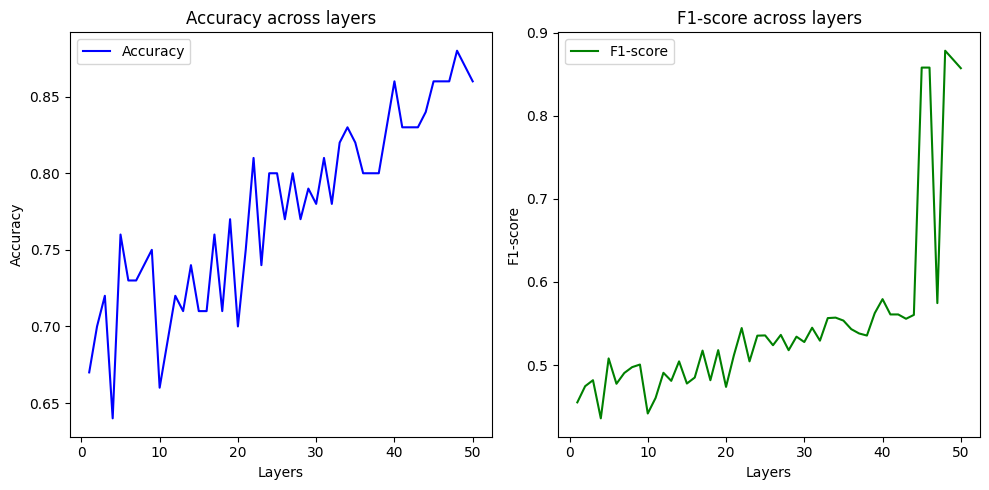

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = wespeaker.load_model_local("/content/extracted_files/voxblink2_samresnet34")
model.set_device(device)

acts_model = GetActivations(model)

def safe_get_activations(model, audio_path, device, target_samples=16000):
    """Безопасная версия get_activations с обработкой ошибок"""
    try:
        waveform, sr = torchaudio.load(str(audio_path))
        feats = process_audio(waveform, sr, target_samples)

        with torch.no_grad():
            activations = model(feats)

        return {
            'file_path': str(audio_path),
            'act': activations[0] if isinstance(activations, tuple) else activations
        }
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

test_files = get_audio_path("/content/extracted_files/TESTSpeechDisorderDataset")
train_files = get_audio_path("/content/extracted_files/SpeechDisorderDataset")

# Фильтрую битые файлы
valid_train_files = [f for f in train_files if is_valid_audio_file(str(f))]
valid_test_files = [f for f in test_files if is_valid_audio_file(str(f))]

print(f"Train files: {len(valid_train_files)}/{len(train_files)} valid")
print(f"Test files: {len(valid_test_files)}/{len(test_files)} valid")

# Получаю активации для первого валидного файла
acts = None
for file in valid_train_files:
    acts = safe_get_activations(acts_model, file, device)
    if acts is not None:
        break

if acts is None:
    raise ValueError("No valid audio files found in training set!")

layers = [list(item.keys())[0] for item in acts['act']]
metrics_list = []

for layer in layers:
    # Обрабатываю только файлы, которые прошли валидацию
    train_acts, train_labels = get_activations_for_layer(
        acts_model, valid_train_files, device, layer,
        [Path(f).parent.name for f in valid_train_files])

    test_acts, test_labels = get_activations_for_layer(
        acts_model, valid_test_files, device, layer,
        [Path(f).parent.name for f in valid_test_files])

    if not train_acts or not test_acts:
        print(f"Skipping layer {layer} due to no valid activations")
        continue

    train_dataset = ActivationDataset(train_acts, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    test_dataset = ActivationDataset(test_acts, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    trained_model = train(
        train_loader, train_dataset.X.shape[-1], layer, device)
    torch.save(trained_model.state_dict(),
              f"/content/extracted_files/Model/{layer}.pth")

    metrics = evaluate(trained_model, test_loader, device)
    metrics_list.append((layer, metrics))

    torch.cuda.empty_cache()

save_metrics(metrics_list, "/content/extracted_files/Result/probing.txt")
plot_metrics(metrics_list, "/content/extracted_files/Result/probing.png")